- srun --time=10:00:00 --gres=gpu:1 --pty bash
- nvidia-smi

In [1]:
import sys
print(sys.executable)

c:\Users\mayeu\.venvs\venvPFE\Scripts\python.exe


In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.5.1+cpu
None
False


In [3]:
import numpy as np
import pandas as pd
import scipy.ndimage
import gcsfs
import xarray as xr
import scipy

## Generate datas

First we need to generate the data by simplifying the era5 grid with the corresponding keys: 'geopotential', 'specific_humidity', 'temperature', 'u_component_of_wind', 'v_component_of_wind', 'sim_time'.

These keys have dimensions (37, 256, 128). 37 corresponds to the pressure level in the atmosphere and (256, 128) corresponds to the coordinates on the earth. 256 is a simplified dimension for longitude and 128 is a simplified dimension for latitude.

We're going to generate data on a simplified model by reducing the dimension by around 8. We therefore have this dimension for our simplified model: (5, 32, 16)

For all key, we will generate data based on the density of these 5 pressure levels ([0, 10, 20, 30, 36]).

In [4]:
""" from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
from dinosaur.spherical_harmonic import Grid

def data_generation(data, 
            demo_start_time = '2020-02-14',
            demo_end_time = '2020-02-18',
            data_inner_steps = 24,  
            input_variables = ['geopotential', 
                                'specific_humidity','temperature',
                                'u_component_of_wind',
                                'v_component_of_wind',
                                'specific_cloud_ice_water_content',
                                'specific_cloud_liquid_water_content'], 
            forcing_variables = ['sea_ice_cover', 'sea_surface_temperature'], 
            longitude_nodes=32, 
            latitude_nodes=16,
            level = [0, 10, 20, 30, 36]):
    

    #full_era5 = data[input_variables + forcing_variables]

    sliced_era5 = (
        data
        [input_variables + forcing_variables]
        .pipe(
            xarray_utils.selective_temporal_shift,
            variables=forcing_variables,
            time_shift='24 hours',
        )
        .sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
        .compute()
    )
    
    # Creating a new Grid object with custom parameters
    custom_grid = Grid(
        longitude_nodes= longitude_nodes,  # Number of grid points in longitude
        latitude_nodes= latitude_nodes,   # Number of grid points in latitude
    )

    full_era5_grid = spherical_harmonic.Grid(
        latitude_nodes=sliced_era5.sizes['latitude'],
        longitude_nodes=sliced_era5.sizes['longitude'],
        latitude_spacing=xarray_utils.infer_latitude_spacing(sliced_era5.latitude),
        longitude_offset=xarray_utils.infer_longitude_offset(sliced_era5.longitude),
    )

    regridder = horizontal_interpolation.ConservativeRegridder(
        full_era5_grid, custom_grid, skipna=True
    )

    #sliced_era5 = sliced_era5.sel(time=dtime).compute()
    regridded = xarray_utils.regrid(sliced_era5, regridder)
    regridded = xarray_utils.fill_nan_with_nearest(regridded)
    regridded = regridded.isel(level=level)
    
    return regridded, sliced_era5 """

" from dinosaur import horizontal_interpolation\nfrom dinosaur import spherical_harmonic\nfrom dinosaur import xarray_utils\nfrom dinosaur.spherical_harmonic import Grid\n\ndef data_generation(data, \n            demo_start_time = '2020-02-14',\n            demo_end_time = '2020-02-18',\n            data_inner_steps = 24,  \n            input_variables = ['geopotential', \n                                'specific_humidity','temperature',\n                                'u_component_of_wind',\n                                'v_component_of_wind',\n                                'specific_cloud_ice_water_content',\n                                'specific_cloud_liquid_water_content'], \n            forcing_variables = ['sea_ice_cover', 'sea_surface_temperature'], \n            longitude_nodes=32, \n            latitude_nodes=16,\n            level = [0, 10, 20, 30, 36]):\n    \n\n    #full_era5 = data[input_variables + forcing_variables]\n\n    sliced_era5 = (\n        data\n       

In [6]:
input_variables =['geopotential', 
                    'specific_humidity','temperature',
                    'u_component_of_wind',
                    'v_component_of_wind',
                    'specific_cloud_ice_water_content',
                    'specific_cloud_liquid_water_content']

forcing_variables = ['sea_ice_cover', 'sea_surface_temperature']

longitude_nodes=32
latitude_nodes=16

longitude_nodes_original = 256
latitude_nodes_original = 128
level_original = [i for i in range(37)]
level = [0, 10, 20, 30, 36]
dtime = '2020-02-14T00'

demo_start_time = '2020-02-14'
demo_end_time = '2020-02-18'
data_inner_steps = 24

path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'

In [7]:
gcs = gcsfs.GCSFileSystem(token='anon')
full_era5 = xr.open_zarr(gcs.get_mapper(path), chunks=None)

In [7]:
from import_era5 import data_generation

regridded, sliced_era5 = data_generation(data = full_era5,
    demo_start_time = '2020-02-14',
    demo_end_time = '2020-02-18',
    data_inner_steps = 24, 
    input_variables = input_variables,
    forcing_variables = forcing_variables,
    longitude_nodes = longitude_nodes,
    latitude_nodes = latitude_nodes,
    level = level)

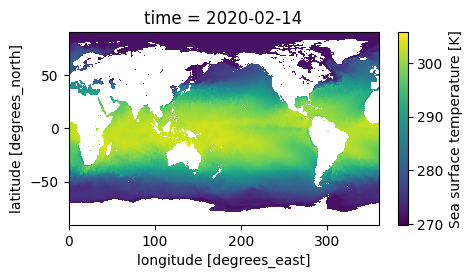

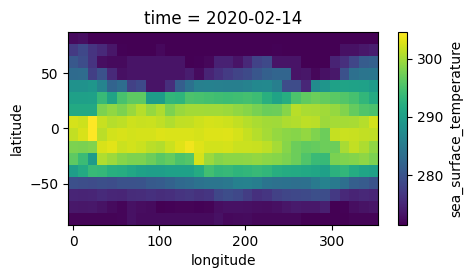

In [8]:
dtime = '2020-02-14T00'
sliced_dtime_era5 = sliced_era5.sel(time=dtime).compute()
regridded_dtime = regridded.sel(time=dtime).compute()

sliced_dtime_era5.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);
regridded_dtime.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);

### Normalization of input features

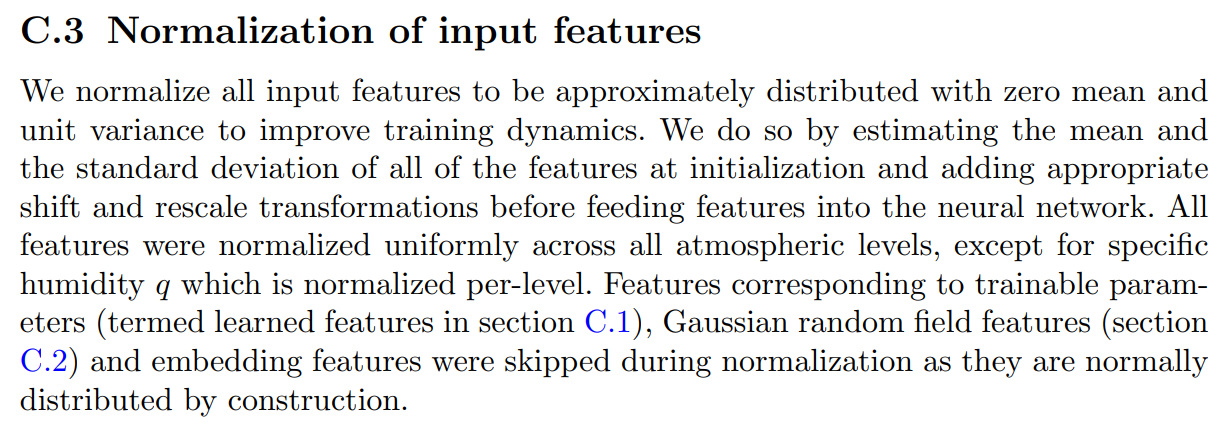

First of all, we normalise the data in order to obtain reduced centred data. And we do so for all the other features. The normalised data is then transferred to encoder (Lounis)

In [9]:
def normalize_z_score(array):
    mean_val = array.mean(dim=array.dims)
    std_val = array.std(dim=array.dims)
    return (array - mean_val) / std_val

In [10]:
normalized_dataset = regridded.copy()

for var in regridded.data_vars:
    dims = regridded[var].dims
    normalized_dataset[var] = normalize_z_score(regridded[var])

## Encoder

### Lounis part

In [8]:
!git clone https://github.com/mylrcd/neuralgcmPFE.git
%pip install -e neuralgcmPFE

import sys
sys.path.append("c:/Users/mayeu/SynologyDrive/DossiersMayeul/Mes Documents/TSP/3A/PFE/NeuralGCM/quickstart/neuralgcmPFE")

from neuralgcmPFE import neuralgcm

model_name = 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl'  #@param ['neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl', 'neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl'] {type: "string"}

import pickle

with gcs.open(f'gs://gresearch/neuralgcm/04_30_2024/{model_name}', 'rb') as f:
    ckpt = pickle.load(f)

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

fatal: destination path 'neuralgcmPFE' already exists and is not an empty directory.


Obtaining file:///C:/Users/mayeu/SynologyDrive/DossiersMayeul/Mes%20Documents/TSP/3A/PFE/NeuralGCM/combinedModel/neuralgcmPFE
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for neuralgcm (pyproject.toml): started
  Building editable for neuralgcm (pyproject.toml): finished with status 'done'
  Created wheel for neuralgcm: filename=neuralgcm-1.0.0-0.editable-py3-none-any.whl size=11510 sha256=303f162b946f30a25d6ebe39e62e825bdc92e6010f44920fc1c1589886a874bc
  Stored in directory: C:\Users\mayeu\AppData\Local\Temp\pip-ephem-whee


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\mayeu\AppData\Local\Temp\ipykernel_64300\3665349786.py:14: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  ckpt = pickle.load(f)


In [12]:
regridded_original, sliced_era5_original = data_generation(data = full_era5,
    demo_start_time = '2020-02-14',
    demo_end_time = '2020-02-18',
    data_inner_steps = 24, 
    input_variables = input_variables,
    forcing_variables = forcing_variables,
    longitude_nodes = longitude_nodes_original,
    latitude_nodes = latitude_nodes_original,
    level = level_original)

In [13]:
from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
from dinosaur.spherical_harmonic import Grid

sliced_era5 = (
    full_era5
    [model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    .sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
    .compute()
)

era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
regridder_origin = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
reggrided_origin = xarray_utils.regrid(sliced_era5, regridder_origin)
reggrided_origin = xarray_utils.fill_nan_with_nearest(reggrided_origin)

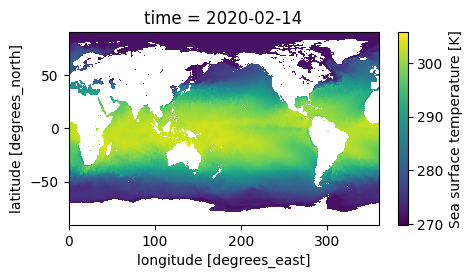

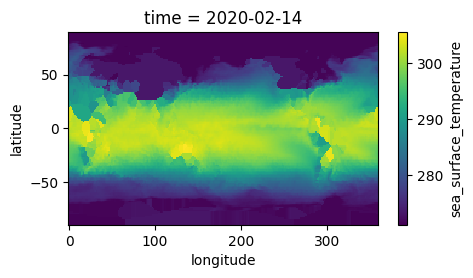

In [14]:
dtime = '2020-02-14T00'
sliced_dtime_era5_original = sliced_era5_original.sel(time=dtime).compute()
regridded_dtime_original = regridded_original.sel(time=dtime).compute()

sliced_dtime_era5_original.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);
regridded_dtime_original.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);

In [ ]:
inner_steps = 24  # save model outputs once every 24 hours
outer_steps = 4 * 24 // inner_steps  # total of 4 days
timedelta = np.timedelta64(1, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)  # time axis in hours

In [15]:
""" initial_state_xr = regridded.isel(time=0)

input_forcings = initial_state_xr.isel(level=0)
input_forcings = input_forcings.expand_dims("level", axis=0)
#input_forcings = regridded
input_forcings = {var: input_forcings[forcing_variables][var].values for var in input_forcings[forcing_variables].data_vars}
inputs = {var: initial_state_xr[input_variables][var].values for var in initial_state_xr[input_variables].data_vars}

sim_time = np.array(189248.050944)
inputs['sim_time'] = sim_time
input_forcings['sim_time'] = sim_time 

for key, value in input_forcings.items():
    print(f"{key}: {value.shape}")
    
dim_1 = 256
dim_2 = 128
dim_0 = 36

inputs = {
    "geopotential": np.random.rand(dim_0, dim_1, dim_2),
    "specific_humidity": np.random.rand(dim_0, dim_1, dim_2), 
    "temperature": np.random.rand(dim_0, dim_1, dim_2),
    "u_component_of_wind": np.random.rand(dim_0, dim_1, dim_2), 
    "v_component_of_wind": np.random.rand(dim_0, dim_1, dim_2), 
    "specific_cloud_ice_water_content": np.random.rand(dim_0, dim_1, dim_2),
    "specific_cloud_liquid_water_content": np.random.rand(dim_0, dim_1, dim_2), 
    "sim_time": np.random.rand(),  # scalar value ()
}

input_forcings = {
    "sea_ice_cover": np.random.rand(1, dim_1, dim_2),  # (1, 512, 128)
    "sea_surface_temperature": np.random.rand(1, dim_1, dim_2),  # (1, 512, 128)
    "sim_time": np.random.rand(),  # scalar value ()
}"""

In [315]:
import numpy as np
import jax
rng_key = jax.random.PRNGKey(42)

states_divergence = np.empty((5, 32, 256, 128), dtype='float32') 
states_log_surface_pressure = np.empty((5, 32, 256, 128), dtype='float32') 
states_vorticity = np.empty((5, 32, 256, 128), dtype='float32') 
states_temperature_deviation = np.empty((5, 32, 256, 128), dtype='float32') 

for i in range(5):
    inputs_original = model.inputs_from_xarray(regridded_original.isel(time=i))
    input_forcings_original = model.forcings_from_xarray(regridded_original.isel(time=i))
    state = model.encode(inputs_original, input_forcings_original, rng_key)
    states_divergence[i] = state.state.divergence[ :, :, :128]
    states_log_surface_pressure[i] = state.state.log_surface_pressure[ :, :, :128]
    states_vorticity [i] = state.state.vorticity[ :, :, :128]
    states_temperature_deviation[i] = state.state.temperature_variation[ :, :, :128]

In [316]:
states_divergence = np.transpose(states_divergence, (1, 0, 2, 3))
states_vorticity = np.transpose(states_vorticity, (1, 0, 2, 3))
states_temperature_deviation = np.transpose(states_temperature_deviation, (1, 0, 2, 3))
states_log_surface_pressure = np.transpose(states_log_surface_pressure, (1, 0, 2, 3))

In [317]:
regridded_original_encode = regridded_original.isel(time=slice(0, 5))
regridded_original_encode = regridded_original_encode.isel(level=slice(0, 32))
regridded_original_encode = regridded_original_encode.isel(time=slice(0, 5))
regridded_original_encode['divergence'] = xr.DataArray(states_divergence, coords=regridded_original_encode.coords, dims=regridded_original_encode.dims)
regridded_original_encode['vorticity'] = xr.DataArray(states_vorticity, coords=regridded_original_encode.coords, dims=regridded_original_encode.dims)
regridded_original_encode['log_surface_pressure'] = xr.DataArray(states_log_surface_pressure, coords=regridded_original_encode.coords, dims=regridded_original_encode.dims)
regridded_original_encode['temperature_deviation'] = xr.DataArray(states_temperature_deviation, coords=regridded_original_encode.coords, dims=regridded_original_encode.dims)

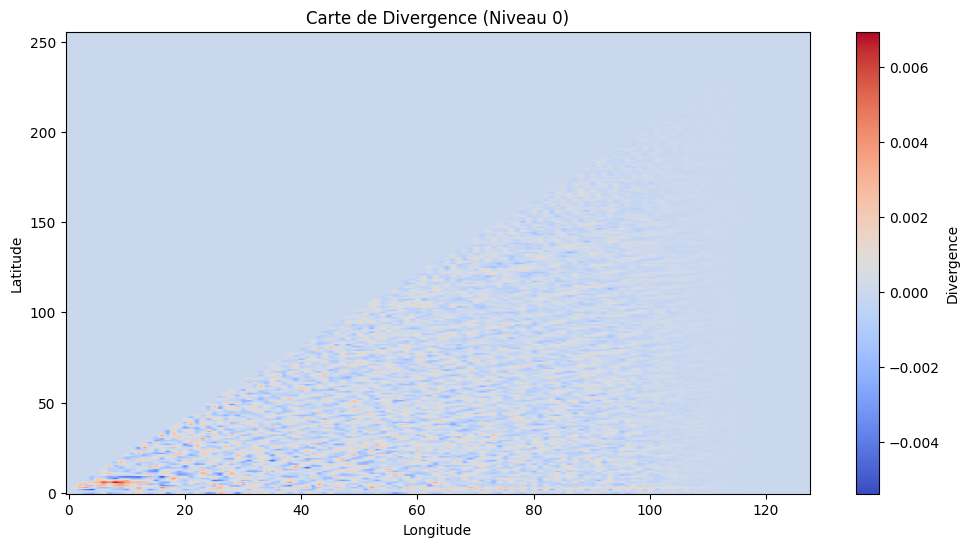

In [330]:
divergence_map = regridded_original_encode.isel(time=0).isel(level=0).divergence.values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.imshow(divergence_map, origin='lower', cmap='coolwarm', aspect='auto')
plt.colorbar(label="Divergence")
plt.title("Carte de Divergence (Niveau 0)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [380]:
from import_era5 import data_rescale

level = [0, 1, 2, 3, 4]

regridded_encode = data_rescale(data = regridded_original_encode,
    longitude_nodes = longitude_nodes,
    latitude_nodes = latitude_nodes,
    level = level)

ImportError: cannot import name 'data_rescale' from 'import_era5' (c:\Users\mayeu\SynologyDrive\DossiersMayeul\Mes Documents\TSP\3A\PFE\NeuralGCM\combinedModel\import_era5.py)

In [377]:
regridded_original_encode.to_netcdf("data/full_encoded_dataa.nc")
regridded_encode.to_netcdf("data/encoded_data.nc")

In [378]:
regridded_original_encode = xr.open_dataset("data/full_encoded_data.nc")
regridded_encode = xr.open_dataset("data/full_encoded_data.nc")

In [379]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import xarray

from dinosaur import coordinate_systems
from dinosaur import filtering
from dinosaur import primitive_equations
from dinosaur import scales
from dinosaur import sigma_coordinates
from dinosaur import spherical_harmonic
from dinosaur import time_integration
from dinosaur import vertical_interpolation

units = scales.units



def attach_data_array_units(array):
    attrs = dict(array.attrs)
    units = attrs.pop('units', None)
    if units in {'(0 - 1)', '%', '~'}:
        units = None
    if units is not None:
        data = scales.units.parse_expression(units) * array.data
    else:
        data = scales.units.dimensionless * array.data
    return xarray.DataArray(data, array.coords, array.dims, attrs=attrs)


def attach_xarray_units(ds):
    return ds.map(attach_data_array_units)


def xarray_nondimensionalize(ds):
    return xarray.apply_ufunc(scales.DEFAULT_SCALE.nondimensionalize, ds)


def xarray_to_gcm_dict(ds, var_names=None):
    if var_names is None:
        var_names = ds.keys()
    result = {}
    for var_name in var_names:
        data = ds[var_name].transpose(..., 'longitude', 'latitude').data
    if data.ndim == 2:  # missing level dimension
        data = data[np.newaxis, ...]
    result[var_name] = data
    return result


def slice_levels(output, level_indices):
    def get_horizontal(x):
        if x.shape[0] == 1:
            return x
        else:
            return x[level_indices, ...]
    return jax.tree.map(get_horizontal, output)


# simulation grid
layers = 32
ref_temp_si = 250 * units.degK
model_coords = coordinate_systems.CoordinateSystem(
    spherical_harmonic.Grid.T170(),
    sigma_coordinates.SigmaCoordinates.equidistant(layers),
)

# timescales
dt_si = 5 * units.minute
save_every = 15 * units.minute
total_time = 2 * units.day + save_every
dfi_timescale = 6 * units.hour

# which levels to output
output_level_indices = [layers // 4, layers // 2, 3*layers // 4, -1]


tracers = {
    'specific_cloud_water': regridded_original_encode['specific_cloud_ice_water_content'],
    'specific_cloud_ice': regridded_original_encode['specific_cloud_ice_water_content'],
    'specific_humidity': regridded_original_encode['specific_cloud_ice_water_content'],
}

# build initial state
raw_init_state = primitive_equations.State(
    vorticity = regridded_original_encode['vorticity'],
    divergence = regridded_original_encode['divergence'],
    temperature_variation = regridded_original_encode['temperature_variation'],
    log_surface_pressure = regridded_original_encode['log_sp'],
    tracers = tracers,
)

# apply reference temperature
physics_specs = primitive_equations.PrimitiveEquationsSpecs.from_si()

ref_temps = physics_specs.nondimensionalize(
    ref_temp_si * np.ones((model_coords.vertical.layers,))
)

# setup a simulation of the dry primitive equations
def normalize_z_score(array):
    mean_val = array.mean(dim=array.dims)
    std_val = array.std(dim=array.dims)
    return (array - mean_val) / std_val

normalized_dataset = regridded.copy()

for var in regridded.data_vars:
    dims = regridded[var].dims
    normalized_dataset[var] = normalize_z_score(regridded[var])

raw_orography = regridded.geopotential.isel(level=0)
desired_lon = 180/np.pi * model_coords.horizontal.nodal_axes[0]
desired_lat = 180/np.pi * np.arcsin(model_coords.horizontal.nodal_axes[1])
ds_init = attach_xarray_units(regridded.compute().interp(latitude=desired_lat, longitude=desired_lon))
ds_init['orography'] = attach_data_array_units(raw_orography.interp(latitude=desired_lat, longitude=desired_lon))
ds_init['orography'] /= scales.GRAVITY_ACCELERATION
ds_nondim_init = xarray_nondimensionalize(ds_init)
model_level_inputs = xarray_to_gcm_dict(ds_nondim_init)
orography_input = model_level_inputs.pop('orography')
orography = model_coords.horizontal.to_modal(orography_input)
orography = filtering.exponential_filter(model_coords.horizontal, order=2)(orography)
eq = primitive_equations.PrimitiveEquations(
    ref_temps, orography, model_coords, physics_specs
)

# setup hyper-spectral filter for running between dycore time-steps
res_factor = model_coords.horizontal.latitude_nodes / 128
dt = physics_specs.nondimensionalize(dt_si)
tau = physics_specs.nondimensionalize(8.6 / (2.4 ** np.log2(res_factor)) * units.hours)
hyperdiffusion_filter = time_integration.horizontal_diffusion_step_filter(
    model_coords.horizontal, dt=dt, tau=tau, order=2
)

# digital filter initialization
time_span = cutoff_period = physics_specs.nondimensionalize(dfi_timescale)
dfi = jax.jit(time_integration.digital_filter_initialization(
    equation=eq,
    ode_solver=time_integration.imex_rk_sil3,
    filters=[hyperdiffusion_filter],
    time_span=time_span,
    cutoff_period=cutoff_period,
    dt=dt,
))

# Conversion des tenseurs PyTorch en JAX
raw_init_state = primitive_equations.State(
    vorticity=jnp.array(vorticity.numpy()),
    divergence=jnp.array(divergence.numpy()),
    temperature_variation=jnp.array(temperature_variation.numpy()),
    log_surface_pressure=jnp.array(log_sp.numpy()),
    tracers={
        'specific_cloud_water': jnp.array(specific_cloud_water.numpy()),
        'specific_cloud_ice': jnp.array(specific_cloud_ice.numpy()),
        'specific_humidity': jnp.array(specific_humidity.numpy()),
    },
)

"""desired_lat = regridded['latitude'].values
desired_lon = regridded['longitude'].values"""

%time dfi_init_state = jax.block_until_ready(dfi(raw_init_state))

KeyError: "No variable named 'temperature_variation'. Variables on the dataset include ['longitude', 'latitude', 'divergence', 'vorticity', 'log_surface_pressure', ..., 'u_component_of_wind', 'v_component_of_wind', 'specific_cloud_ice_water_content', 'specific_cloud_liquid_water_content', 'time']"

## Learn Physic part

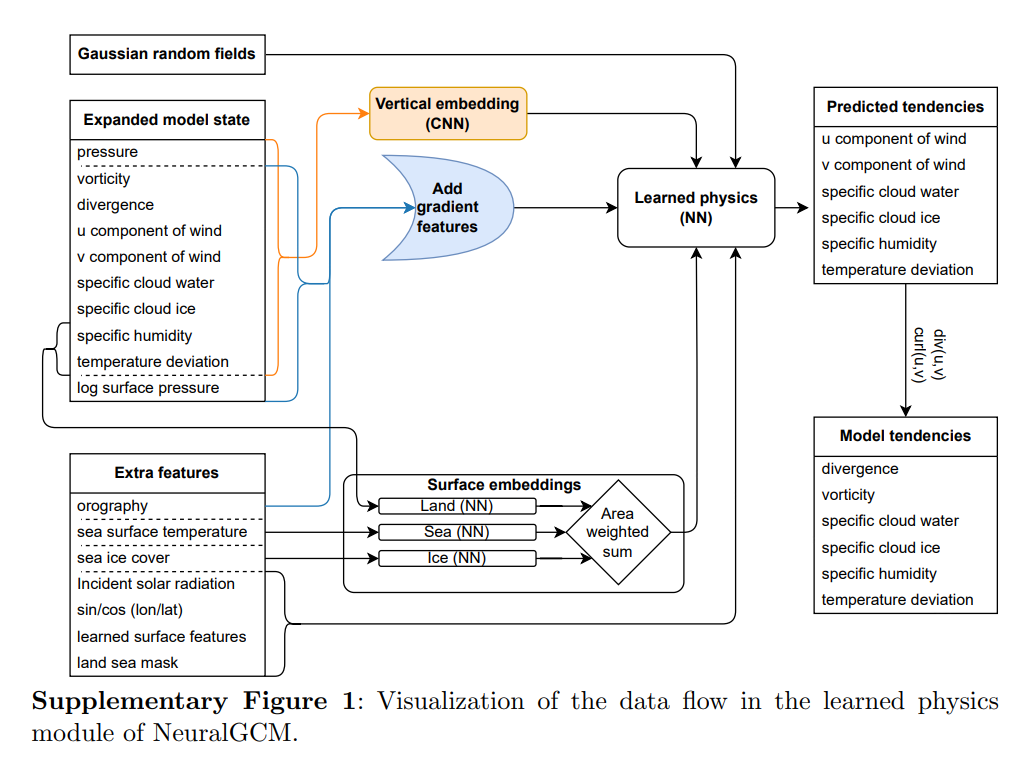

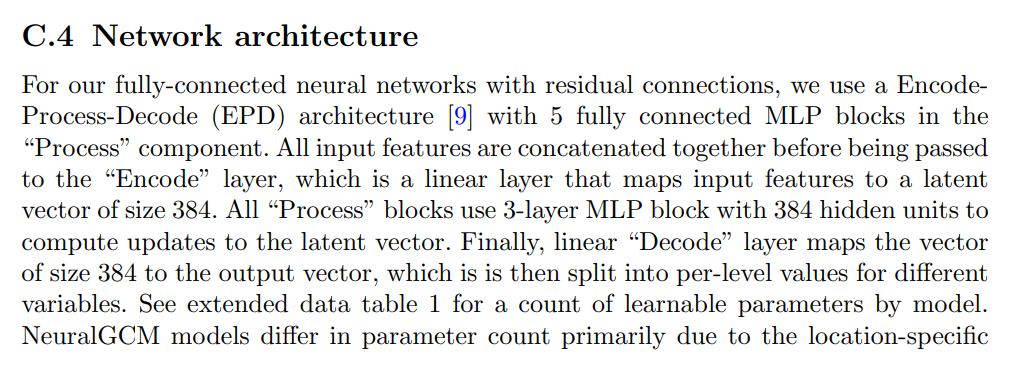

### Vertical embedding network

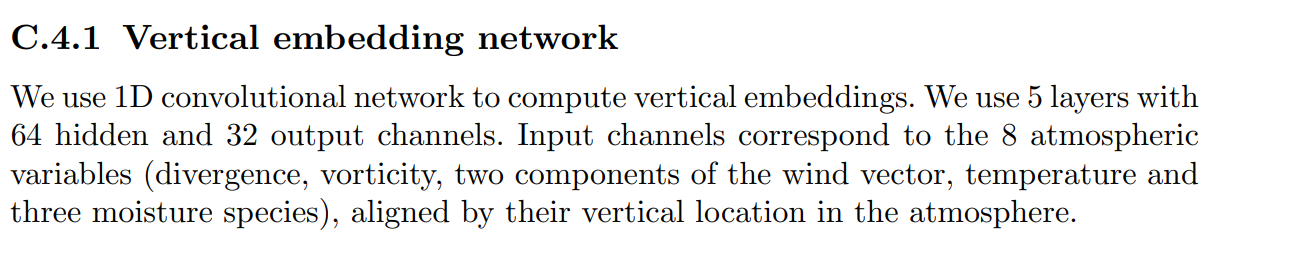

In [38]:
input_channels = 8
hidden_channels = 64
output_channels = 32
num_layers = 5
vertical_dim = 5

x = torch.rand(16, input_channels, vertical_dim)
x.shape

torch.Size([16, 8, 5])

For the learned physics module, we gonna first generate random data.

In [39]:
vorticity = torch.empty((5, 32, 16))
divergence = torch.empty((5, 32, 16))
u_component_of_wind = torch.empty((5, 32, 16))
v_component_of_wind = torch.empty((5, 32, 16))
specific_cloud_water = torch.empty((5, 32, 16))
specific_cloud_ice = torch.empty((5, 32, 16))
specific_humidity = torch.empty((5, 32, 16))
temperature_deviation = torch.empty((5, 32, 16))

def generate_data(shape):
    data = torch.normal(mean=0, std=1, size=shape).numpy()
    data = scipy.ndimage.gaussian_filter(data, sigma=2)
    return torch.tensor(data)

for i in range(5):
    vorticity[i] = generate_data((32, 16))
    divergence[i] = generate_data((32, 16))
    u_component_of_wind[i] = generate_data((32, 16))
    v_component_of_wind[i] = generate_data((32, 16))
    specific_cloud_water[i] = generate_data((32, 16))
    specific_cloud_ice[i] = generate_data((32, 16))
    specific_humidity[i] = generate_data((32, 16))
    temperature_deviation[i] = generate_data((32, 16))

features = torch.stack([ 
    vorticity, 
    divergence, 
    u_component_of_wind, 
    v_component_of_wind, 
    specific_cloud_water, 
    specific_cloud_ice, 
    specific_humidity, 
    temperature_deviation
])

data = features.permute(2, 3, 0, 1) # (latitude, longitude, variables, vertical_dim)
data = data.reshape(-1, 8, 5)  # (batch_size=32*16, input_channels=8, sequence_length=5)

print("Shape of data tensor:", data.shape)
print("Shape of features tensor:", features.shape)

Shape of data tensor: torch.Size([512, 8, 5])
Shape of features tensor: torch.Size([8, 5, 32, 16])


In [40]:
from learnedPhysics import VerticalEmbeddingNetwork

model_VEN = VerticalEmbeddingNetwork()
output_VEN = model_VEN(data)
output_VEN.shape

torch.Size([512, 32, 5])

In [41]:
regridded

<xarray.Dataset> Size: 76kB
Dimensions:                              (level: 5, longitude: 32, latitude: 16)
Coordinates:
  * level                                (level) int64 40B 1 100 450 850 1000
    time                                 datetime64[ns] 8B 2020-01-01
  * longitude                            (longitude) float64 256B 0.0 ... 348.8
  * latitude                             (latitude) float64 128B -81.65 ... 8...
Data variables:
    geopotential                         (level, longitude, latitude) float32 10kB ...
    specific_humidity                    (level, longitude, latitude) float32 10kB ...
    temperature                          (level, longitude, latitude) float32 10kB ...
    u_component_of_wind                  (level, longitude, latitude) float32 10kB ...
    v_component_of_wind                  (level, longitude, latitude) float32 10kB ...
    specific_cloud_ice_water_content     (level, longitude, latitude) float32 10kB ...
    specific_cloud_liquid_water_content  (level, longitude, latitude) float32 10kB ...
    sea_ice_cover                        (longitude, latitude) float32 2kB 0....
    sea_surface_temperature              (longitude, latitude) float32 2kB 27...

### Surface embedding network

In [42]:
sea_ice_cover = torch.empty((5, 32, 16))
sea_surface_temperature = torch.empty((5, 32, 16))
temperature_deviation = torch.empty((5, 32, 16))
specific_humidity = torch.empty((5, 32, 16))

for i in range(5):
    sea_ice_cover[i] = generate_data((32, 16))
    sea_surface_temperature[i] = generate_data((32, 16))
    temperature_deviation[i] = generate_data((32, 16))
    specific_humidity[i] = generate_data((32, 16))

sea_input = sea_surface_temperature
ice_input = sea_ice_cover 
land_input = torch.stack([ temperature_deviation, specific_humidity])

sea_input = sea_input.permute(1, 2, 0)
sea_input = sea_input.reshape(-1, 5)
sea_input = sea_input.reshape(-1, 1)

ice_input = ice_input.permute(1, 2, 0)
ice_input = ice_input.reshape(-1, 5)
ice_input = ice_input.reshape(-1, 1)

land_input = land_input.permute(2, 3, 0, 1) # (latitude, longitude, variables, vertical_dim)
land_input = land_input.reshape(-1, 2, 5)  # (batch_size=32*16, input_channels=8, sequence_length=5)
land_input = land_input.reshape(-1, 2)

print("Shape of sea_input tensor:", sea_input.shape)
print("Shape of ice_input tensor:", ice_input.shape)
print("Shape of land_input tensor:", land_input.shape)

Shape of sea_input tensor: torch.Size([2560, 1])
Shape of ice_input tensor: torch.Size([2560, 1])
Shape of land_input tensor: torch.Size([2560, 2])


In [29]:
import torch
import torch.nn as nn

class SurfaceEmbeddingNetwork(nn.Module):
    def __init__(self, surface_type):
        super(SurfaceEmbeddingNetwork, self).__init__()
        self.surface_type = surface_type
        
        if self.surface_type == 'sea' :
            self.net = nn.Sequential(
                nn.Linear(in_features = 1, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 8)
            )
        
        elif self.surface_type == 'land' :
            self.net = nn.Sequential(
                nn.Linear(in_features = 2, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 8)
            )   
            
        elif self.surface_type == 'ice' :
            self.net = nn.Sequential(
                nn.Linear(in_features = 1, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 16),
                nn.ReLU(),
                nn.Linear(in_features = 16, out_features = 8)
            )
        
    def forward(self, x) :
        x = self.net(x)
        return x
    
class AreaWeightedSum(nn.Module):
    def __init__(self):
        super(AreaWeightedSum, self).__init__()
    
    def forward(self, sea_embedding, land_embedding, ice_embedding, sea_fraction, land_fraction, ice_fraction):
        return sea_embedding * sea_fraction + land_embedding * land_fraction + ice_embedding * ice_fraction


In [30]:
#from learnedPhysics import SurfaceEmbeddingNetwork, AreaWeightedSum

sea_net = SurfaceEmbeddingNetwork(surface_type='sea')
land_net = SurfaceEmbeddingNetwork(surface_type='land')
ice_net = SurfaceEmbeddingNetwork(surface_type='ice')

sea_embedding = sea_net(sea_input)
land_embedding = land_net(land_input)
ice_embedding = ice_net(ice_input)

print(sea_embedding.shape)
print(land_embedding.shape)
print(ice_embedding.shape)

torch.Size([2560, 8])
torch.Size([2560, 8])
torch.Size([2560, 8])


In [15]:


land_fraction = torch.randn(10, 1)  # Fraction de terre à chaque point de la grille
sea_fraction = torch.randn(10, 1)   # Fraction de mer à chaque point de la grille
ice_fraction = torch.randn(10, 1)   # Fraction de glace de mer à chaque point de la grille

# Calcul de la somme pondérée par la surface
area_weighted_sum = AreaWeightedSum()
final_embedding = area_weighted_sum(land_embedding, sea_embedding, ice_embedding, land_fraction, sea_fraction, ice_fraction)

print("Final Area Weighted Sum:", final_embedding.shape)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x5 and 1x16)

Output size of Vertical Embedding Module is [512, 32, 5] \
Output size of Surface Embedding Module is [10, 8]

In [ ]:
import torch
import torch.nn as nn

class EPDNetwork(nn.Module):
    def __init__(self, vertical_embedding_size, surface_embedding_size, latent_size=384, num_process_blocks=5, hidden_units=384):
        super(EPDNetwork, self).__init__()

        # Encode : Couche linéaire pour encoder les entrées combinées
        self.encode = nn.Linear(vertical_embedding_size + surface_embedding_size, latent_size)

        # Process : Bloc MLP pour traiter le vecteur latent
        self.process_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(latent_size, hidden_units),
                nn.ReLU(),
                nn.Linear(hidden_units, hidden_units),
                nn.ReLU(),
                nn.Linear(hidden_units, latent_size)
            )
            for _ in range(num_process_blocks)
        ])

        # Decode : Couche linéaire pour décoder le vecteur latent en sortie
        self.decode = nn.Linear(latent_size, 3)  # Par exemple, 3 variables à prédire (vent, température, humidité)

    def forward(self, vertical_embedding, surface_embedding):
        # Concaténer les embeddings verticaux et de surface
        x = torch.cat((vertical_embedding, surface_embedding), dim=-1)
        
        # Encoder : projeté vers l'espace latent
        x = self.encode(x)
        
        # Process : passer à travers les blocs MLP avec connexions résiduelles
        for block in self.process_blocks:
            x_residual = x  # Connexion résiduelle
            x = block(x)
            x += x_residual 


        output = self.decode(x)
        return output

vertical_embedding_size = 32  # Taille de l'output du VerticalEmbedding
surface_embedding_size = 8    # Taille de l'output du SurfaceEmbedding

model_epd = EPDNetwork(vertical_embedding_size, surface_embedding_size)

# Exemple d'entrées (embeddings simulés)
vertical_embedding = torch.randn(1, vertical_embedding_size)  # Exemple de batch de taille 1
surface_embedding = torch.randn(1, surface_embedding_size)

# Prédiction des tendances physiques (vent, température, humidité)
predicted_tendencies = model_epd(vertical_embedding, surface_embedding)
print(predicted_tendencies)


tensor([[-0.6804, -0.1314, -0.2852]], grad_fn=<AddmmBackward0>)


In [34]:
import torch
import torch.nn as nn
from torch.nn import Transformer

class TransformerEPDNetwork(nn.Module):
    def __init__(self, vertical_embedding_size, surface_embedding_size, latent_size=384, num_process_blocks=5, num_heads=8, num_encoder_layers=6, hidden_units=384):
        super(TransformerEPDNetwork, self).__init__()

        # Encode : Couche linéaire pour encoder les entrées combinées
        self.encode = nn.Linear(vertical_embedding_size + surface_embedding_size, latent_size)

        # Transformer Encoder
        self.transformer = Transformer(d_model=latent_size, nhead=num_heads, num_encoder_layers=num_encoder_layers, dim_feedforward=hidden_units)

        # Decode : Couche linéaire pour décoder le vecteur latent en sortie
        self.decode = nn.Linear(latent_size, 3)  # Par exemple, 3 variables à prédire (vent, température, humidité)

    def forward(self, vertical_embedding, surface_embedding):
        # Concaténer les embeddings verticaux et de surface
        x = torch.cat((vertical_embedding, surface_embedding), dim=-1)
        
        # Encoder : projeté vers l'espace latent
        x = self.encode(x)

        # Transformer : Appliquer le Transformer Encoder
        # Transformer attend une entrée de forme (seq_len, batch_size, features)
        # Ici, la séquence est de taille 1 et nous avons un batch_size de N (toutes les données en même temps)
        x = x.unsqueeze(0)  # Ajouter la dimension de séquence (seq_len=1)
        x = self.transformer(x, x)  # Appliquer l'attention Transformer
        
        # Après le transformer, nous avons un vecteur de sortie de dimension latent_size
        # Nous récupérons la sortie du premier élément de la séquence
        x = x.squeeze(0)  # Retirer la dimension de séquence

        # Decoder : décoder le vecteur latent en la sortie
        output = self.decode(x)
        return output

vertical_embedding_size = 32  # Taille de l'output du VerticalEmbedding
surface_embedding_size = 8    # Taille de l'output du SurfaceEmbedding

model_transformer_epd = TransformerEPDNetwork(vertical_embedding_size, surface_embedding_size)

vertical_embedding = torch.randn(1, vertical_embedding_size)  # Exemple de batch de taille 1
surface_embedding = torch.randn(1, surface_embedding_size)

predicted_tendencies = model_transformer_epd(vertical_embedding, surface_embedding)
print(predicted_tendencies)


c:\Users\mayeu\.venvs\venvPFE\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


tensor([[-0.1193, -0.2190, -0.1763]], grad_fn=<AddmmBackward0>)


### Network output scaling